In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from textblob import TextBlob
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import gensim
from gensim import corpora

# Download NLTK resources
nltk.download('stopwords')
nltk.download('punkt')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nitin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\nitin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [15]:
# Load the data
file_path = 'logs - logs.csv'  # Replace with the actual file path
data = pd.read_csv(file_path)

# Sort data by timestamp
data_sorted = data.sort_values(by='timestamp')

# Display the first few rows of the sorted data
data_sorted.head()


,timestamp,observed_timestamp,id,trace_id,span_id,trace_flags,severity_text,severity_number,body,resources_string_key,resources_string_value,attributes_string_key,attributes_string_value,attributes_int64_key,attributes_int64_value,attributes_float64_key,attributes_float64_value,attributes_bool_key,attributes_bool_value
8141,1.714740e+18,1.714744e+18,2fxVpIEdOkEKkTsSs1rPt7FDk3Q,NaN,NaN,0,NaN,0,Convert conversion successful,[],[],"['container_name','container_id']","['currency-service','opsfree']",[],[],[],[],[],[]
9665,1.714740e+18,1.714744e+18,2fxVpIEdOkEKkTsSs1rPt7FDkS0,NaN,NaN,0,NaN,0,Order confirmation email sent to: bill@example...,[],[],"['container_id','container_name']","['opsfree','email-service']",[],[],[],[],[],[]
9666,1.714740e+18,1.714744e+18,2fxVpIEdOkEKkTsSs1rPt7FDkS1,NaN,NaN,0,NaN,0,"{""message"":""order confirmation email sent to \...",[],[],"['container_name','container_id']","['checkout-service','opsfree']",[],[],[],[],[],[]
9667,1.714740e+18,1.714744e+18,2fxVpIEdOkEKkTsSs1rPt7FDkS2,NaN,NaN,0,NaN,0,"172.18.0.27 - - [03/May/2024:13:52:12 +0000] ""...",[],[],"['container_name','container_id']","['email-service','opsfree']",[],[],[],[],[],[]
9668,1.714740e+18,1.714744e+18,2fxVpIEdOkEKkTsSs1rPt7FDkS3,NaN,NaN,0,NaN,0,"{""message"":""Successful to write message. offse...",[],[],"['container_id','container_name']","['opsfree','checkout-service']",[],[],[],[],[],[]


          timestamp  observed_timestamp    trace_flags  severity_number
count  1.349610e+05        1.349610e+05  134961.000000    134961.000000
mean   1.714749e+18        1.714747e+18       0.080386         0.725832
std    3.074181e+12        1.622896e+12       0.271891         2.455836
min    1.714740e+18        1.714740e+18       0.000000         0.000000
25%    1.714750e+18        1.714746e+18       0.000000         0.000000
50%    1.714750e+18        1.714748e+18       0.000000         0.000000
75%    1.714750e+18        1.714748e+18       0.000000         0.000000
max    1.714750e+18        1.714750e+18       1.000000        13.000000
INFO    10789
WARN       66
Name: severity_text, dtype: int64


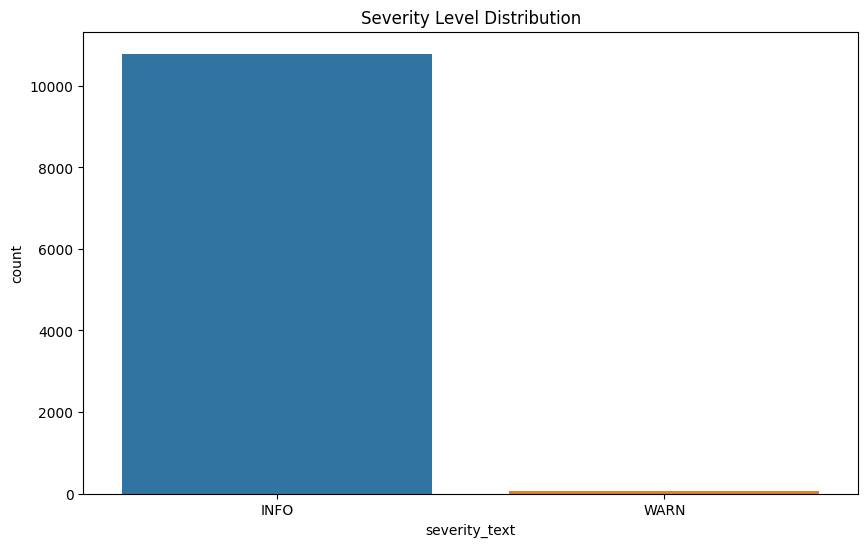

In [16]:
# Summary statistics for numerical columns
print(data_sorted.describe())

# Distribution of severity levels
severity_distribution = data_sorted['severity_text'].value_counts()
print(severity_distribution)

# Plotting the severity distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=data_sorted, x='severity_text', order=severity_distribution.index)
plt.title('Severity Level Distribution')
plt.show()


In [17]:
# Extract the body text for NLP analysis
body_text = data_sorted['body'].astype(str)

# Tokenization and Frequency Analysis
vectorizer = CountVectorizer(stop_words='english')
body_word_counts = vectorizer.fit_transform(body_text)

# Summarize the word counts
word_counts = pd.DataFrame(body_word_counts.sum(axis=0), columns=vectorizer.get_feature_names_out(), index=["count"]).T
word_counts_sorted = word_counts.sort_values(by="count", ascending=False)

# Display the top 10 most frequent words
print(word_counts_sorted.head(10))


              count
2024          51785
05            50396
info          45015
03            40073
11ef          37698
14            35748
userid        32744
called        32655
0242ac12001d  30900
message       29524


                                                   body  sentiment
8141                      Convert conversion successful       0.75
9665  Order confirmation email sent to: bill@example...       0.00
9666  {"message":"order confirmation email sent to \...       0.00
9667  172.18.0.27 - - [03/May/2024:13:52:12 +0000] "...       0.00
9668  {"message":"Successful to write message. offse...       0.75


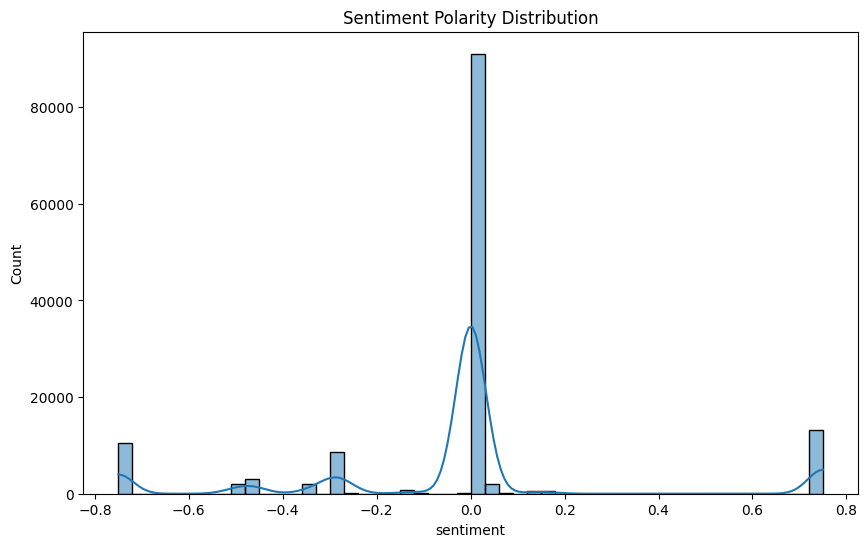

In [18]:
# Apply sentiment analysis to the body column, handling non-string values
data_sorted['sentiment'] = data_sorted['body'].apply(
    lambda x: TextBlob(x).sentiment.polarity if isinstance(x, str) else None
)

# Display a few rows to check the sentiment analysis
print(data_sorted[['body', 'sentiment']].head())

# Plotting the sentiment distribution
plt.figure(figsize=(10, 6))
sns.histplot(data_sorted['sentiment'], bins=50, kde=True)
plt.title('Sentiment Polarity Distribution')
plt.show()


In [19]:
# Preprocess the text, handling non-string values
stop_words = set(stopwords.words('english'))

data_processed = data_sorted['body'].apply(
    lambda x: [word for word in word_tokenize(x.lower()) if word.isalnum() and word not in stop_words] if isinstance(x, str) else []
)

# Display the processed text for the first few rows
data_processed.head()



8141                    [convert, conversion, successful]
9665             [order, confirmation, email, sent, bill]
9666    [message, order, confirmation, email, sent, bi...
9667                                          [post, 200]
9668    [message, successful, write, message, offset, ...
Name: body, dtype: object

In [20]:
# Create a dictionary representation of the documents.
dictionary = corpora.Dictionary(data_processed)

# Create a corpus: Bag of Words
corpus = [dictionary.doc2bow(text) for text in data_processed]

# Build LDA model
lda_model = gensim.models.LdaModel(corpus, num_topics=5, id2word=dictionary, passes=15)

# Print the topics found by the LDA model
for idx, topic in lda_model.print_topics(-1):
    print(f"Topic: {idx} \nWords: {topic}\n")

Topic: 0 
Words: 0.046*"address" + 0.046*"extensions" + 0.042*"cartitem" + 0.042*"quantity" + 0.041*"info" + 0.030*"message" + 0.024*"metadata" + 0.023*"getquoterequest" + 0.023*"request" + 0.023*"state"

Topic: 1 
Words: 0.135*"called" + 0.113*"getcartasync" + 0.069*"info" + 0.043*"sent" + 0.042*"order" + 0.042*"confirmation" + 0.042*"email" + 0.035*"snapshot" + 0.033*"1" + 0.031*"ad"

Topic: 2 
Words: 0.065*"message" + 0.047*"info" + 0.043*"timestamp" + 0.025*"offset" + 0.022*"pid" + 0.022*"orderid" + 0.022*"msg" + 0.022*"level" + 0.022*"614f2cd08e00" + 0.022*"hostname"

Topic: 3 
Words: 0.052*"severity" + 0.052*"message" + 0.052*"timestamp" + 0.051*"additemasync" + 0.050*"called" + 0.041*"info" + 0.036*"200" + 0.035*"request" + 0.035*"post" + 0.018*"charge"

Topic: 4 
Words: 0.186*"successful" + 0.186*"conversion" + 0.186*"convert" + 0.059*"info" + 0.035*"deleted" + 0.025*"snapshot" + 0.023*"offset" + 0.023*"producer" + 0.016*"log" + 0.015*"index"



Based on the EDA performed, the following approaches are recommended for anomaly detection in the log data:

1. **Isolation Forest**: An unsupervised machine learning algorithm effective for high-dimensional data.
2. **Autoencoders (Deep Learning)**: Suitable for identifying anomalies by reconstructing input and detecting high reconstruction errors.
3. **Time Series Analysis**: For example, the Seasonal Hybrid Extreme Studentized Deviate (S-H-ESD) method, effective for time-series anomaly detection.
